<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/NNNGP_4pt_coupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import quad
from tqdm import tqdm

In [5]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [6]:
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

In [7]:
X_Gauss = np.array([[-0.01], [-0.006], [-0.002], [0.002], [0.006], [0.01]])
X_erf = np.array([[0.002], [0.004], [0.006], [0.008], [0.010], [0.012]])
X_ReLU = np.array([[0.2], [0.4], [0.6], [0.8], [1.0], [1.2]])

### Find all distinct combination of $G^{(n)}$

In [8]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [9]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### $\Delta_{1234y}$

In [4]:
def integrand(t, x1, x2, x3, x4, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t)

### $\int d^{d_{in}}y \; \Delta_{1234y}$

In [10]:
def compute_integral(X, comb, K, Lambda, integrand=integrand):
    res = []
    for c in comb:
        x1, x2, x3, x4 = X[c]
        res.append(quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, K))[0])
    return dict(zip([tuple(c) for c in comb], res))

In [119]:
x = np.linspace(-30, 30, 10000)

y = np.array([integrand(i, 0.002, 0.002, 0.002, 0.002, Kw_erf) for i in x])

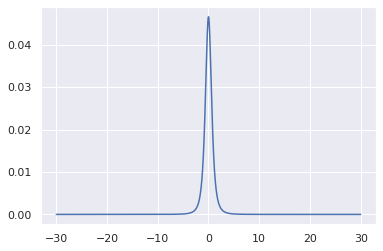

In [120]:
plt.plot(x,y)
plt.show()

## Gauss-net

### Gauss-net $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [ ]:
def K_Gauss(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    return sigmab2 + sigmaw2 * np.exp(-sigmaw2 * np.square(x - y) / (2.0*d_in))

In [ ]:
def Kw_Gauss(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    return sigmaw2 * np.exp(-sigmaw2 * np.square(x - y) / (2.0*d_in))

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$ and save the results

In [ ]:
%%time
integral = compute_integral(X_Gauss.reshape(-1), comb4, Kw_Gauss, np.inf)

CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 636 ms


### Compute $K_W(x_i, x_j)$ and save the results

In [18]:
def compute_K(X, comb, K):
    K_values = []
    for c in comb:
        x1, x2 = X[c]
        K_values.append(K(x1, x2))
    return dict(zip([tuple(c) for c in comb], K_values))

In [ ]:
K_values = compute_K(X_Gauss.reshape(-1), comb2, K_Gauss)

In [ ]:
K_values

{(0, 0): 2.0,
 (0, 1): 1.999992000032,
 (0, 2): 1.9999680005119944,
 (0, 3): 1.999928002591938,
 (0, 4): 1.9998720081916503,
 (0, 5): 1.9998000199986667,
 (1, 1): 2.0,
 (1, 2): 1.999992000032,
 (1, 3): 1.9999680005119944,
 (1, 4): 1.999928002591938,
 (1, 5): 1.9998720081916503,
 (2, 2): 2.0,
 (2, 3): 1.999992000032,
 (2, 4): 1.9999680005119944,
 (2, 5): 1.999928002591938,
 (3, 3): 2.0,
 (3, 4): 1.999992000032,
 (3, 5): 1.9999680005119944,
 (4, 4): 2.0,
 (4, 5): 1.999992000032,
 (5, 5): 2.0}

### Load experimental $f(x)$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/Gauss/'
files = list(pathlib.Path(dir).glob('*'))
lambdam = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam.append((A - G4) / B)

100%|██████████| 10/10 [07:02<00:00, 42.26s/it]


### Plot $\lambda_m$

In [ ]:
lambdam_df = pd.DataFrame(np.log10(np.abs(lambdam).reshape(10, -1)))
lambdam_df.index = np.log10(Ns)

In [ ]:
lambdam_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0.301030,0.440796,0.440807,0.440823,0.440843,0.440868,0.440815,0.440836,0.440861,0.440890,0.440853,0.440883,0.440917,0.440910,0.440949,0.440986,0.440821,0.440846,0.440876,0.440910,0.440869,0.440903,0.440942,0.440935,0.440979,0.441020,0.440889,0.440928,0.440971,0.440964,0.441012,0.441058,0.440998,0.441051,0.441102,0.441150,0.440825,0.440854,0.440889,0.440928,0.440881,...,0.441058,0.441121,0.441181,0.441238,0.440947,0.441001,0.441058,0.441051,0.441114,0.441173,0.441099,0.441166,0.441231,0.441293,0.441145,0.441216,0.441286,0.441353,0.441417,0.440972,0.441029,0.441092,0.441085,0.441152,0.441216,0.441137,0.441209,0.441278,0.441345,0.441187,0.441264,0.441338,0.441410,0.441479,0.441235,0.441316,0.441395,0.441471,0.441545,0.441617
0.477121,0.166251,0.166324,0.166402,0.166484,0.166571,0.166395,0.166477,0.166564,0.166656,0.166557,0.166649,0.166745,0.166738,0.166839,0.166937,0.166463,0.166550,0.166642,0.166738,0.166634,0.166731,0.166831,0.166824,0.166930,0.167033,0.166716,0.166817,0.166923,0.166916,0.167026,0.167133,0.167011,0.167126,0.167238,0.167348,0.166529,0.166620,0.166716,0.166817,0.166709,...,0.167196,0.167319,0.167441,0.167560,0.166962,0.167076,0.167196,0.167189,0.167312,0.167434,0.167298,0.167427,0.167553,0.167676,0.167405,0.167538,0.167669,0.167797,0.167923,0.167048,0.167167,0.167291,0.167284,0.167412,0.167538,0.167398,0.167531,0.167662,0.167790,0.167510,0.167648,0.167783,0.167916,0.168046,0.167619,0.167762,0.167901,0.168039,0.168174,0.168306
0.602060,0.180641,0.180227,0.179817,0.179411,0.179009,0.179810,0.179404,0.179002,0.178604,0.178995,0.178597,0.178203,0.178196,0.177806,0.177413,0.179390,0.178988,0.178590,0.178196,0.178583,0.178189,0.177799,0.177792,0.177406,0.177016,0.178175,0.177785,0.177398,0.177391,0.177009,0.176624,0.176995,0.176617,0.176235,0.175851,0.178967,0.178569,0.178175,0.177785,0.178168,...,0.176193,0.175822,0.175449,0.175072,0.176945,0.176567,0.176193,0.176185,0.175815,0.175442,0.175801,0.175435,0.175065,0.174693,0.175413,0.175051,0.174686,0.174317,0.173946,0.176538,0.176164,0.175794,0.175787,0.175420,0.175051,0.175406,0.175044,0.174678,0.174310,0.175022,0.174664,0.174303,0.173938,0.173571,0.174636,0.174282,0.173924,0.173564,0.173200,0.172834
0.698970,0.040915,0.041069,0.041230,0.041398,0.041572,0.041223,0.041391,0.041565,0.041745,0.041558,0.041738,0.041926,0.041919,0.042113,0.042307,0.041376,0.041551,0.041731,0.041919,0.041724,0.041912,0.042106,0.042099,0.042300,0.042500,0.041898,0.042092,0.042293,0.042285,0.042493,0.042700,0.042479,0.042693,0.042907,0.043120,0.041529,0.041710,0.041898,0.042092,0.041890,...,0.042864,0.043092,0.043320,0.043547,0.042429,0.042644,0.042864,0.042857,0.043085,0.043312,0.043071,0.043305,0.043540,0.043773,0.043284,0.043525,0.043766,0.044007,0.044247,0.042615,0.042836,0.043064,0.043057,0.043291,0.043525,0.043277,0.043518,0.043759,0.044000,0.043497,0.043745,0.043993,0.044240,0.044488,0.043717,0.043972,0.044226,0.044480,0.044735,0.044988
1.000000,-0.264648,-0.264662,-0.264670,-0.264672,-0.264668,-0.264677,-0.264679,-0.264675,-0.264665,-0.264682,-0.264672,-0.264655,-0.264662,-0.264640,-0.264619,-0.264693,-0.264689,-0.264679,-0.264662,-0.264686,-0.264669,-0.264647,-0.264654,-0.264626,-0.264598,-0.264683,-0.264661,-0.264632,-0.264639,-0.264605,-0.264571,-0.264619,-0.264578,-0.264538,-0.264500,-0.264710,-0.264700,-0.264683,-0.264661,-0.264690,...,-0.264580,-0.264528,-0.264476,-0.264425,-0.264668,-0.264627,-0.264580,-0.264587,-0.264535,-0.264483,-0.264549,-0.264490,-0.264432,-0.264375,-0.264511,-0.264446,-0.264382,-0.264319,-0.264257,-0.264655,-0.264608,-0.264556,-0.264563,-0.264504,-0.264446,-0.264518,-0.264453,-0.264389,-0.264326,-0.264474,-0.264403,-0.264333,-0.264264,-0.264196,-0.264431,-0.264354,-0.264278,-0.264203,-0.264129,-0.2

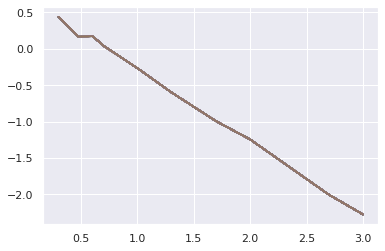

In [ ]:
ax = lambdam_df.plot(legend=False)
plt.show()

## ReLU-net

### $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [11]:
def K_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):

    return sigmab2 + 0.5 * x * y

In [12]:
def Kw_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    return 0.5 * x * y

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$ and save the results

In [13]:
%%time
integral = compute_integral(X_ReLU.reshape(-1), comb4, Kw_ReLU, 100000)

CPU times: user 8.6 ms, sys: 0 ns, total: 8.6 ms
Wall time: 12 ms


### Compute $K_W(x_i, x_j)$ and save the results

In [ ]:
K_values = compute_K(X_ReLU.reshape(-1), comb2, K_ReLU)

In [ ]:
K_values

{(0, 0): 0.020000000000000004,
 (0, 1): 0.04000000000000001,
 (0, 2): 0.06,
 (0, 3): 0.08000000000000002,
 (0, 4): 0.1,
 (0, 5): 0.12,
 (1, 1): 0.08000000000000002,
 (1, 2): 0.12,
 (1, 3): 0.16000000000000003,
 (1, 4): 0.2,
 (1, 5): 0.24,
 (2, 2): 0.18,
 (2, 3): 0.24,
 (2, 4): 0.3,
 (2, 5): 0.36,
 (3, 3): 0.32000000000000006,
 (3, 4): 0.4,
 (3, 5): 0.48,
 (4, 4): 0.5,
 (4, 5): 0.6,
 (5, 5): 0.72}

### Load experimental $f(x)$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/ReLU/'
files = list(pathlib.Path(dir).glob('*'))
lambdam_ReLU = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam_ReLU.append((A - G4) / B)

100%|██████████| 10/10 [07:14<00:00, 43.42s/it]


### Plot $\lambda_m$

In [ ]:
lambdam_ReLU_df = pd.DataFrame(np.log10(np.abs(lambdam_ReLU).reshape(10, -1)))
lambdam_ReLU_df.index = np.log10(Ns)

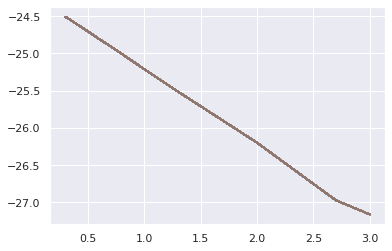

In [ ]:
ax = lambdam_ReLU_df.plot(legend=False)
plt.show()

## Erf-net

### $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [14]:
def K_erf(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((1.0 + 2.0*sigmab2 + 2.0*sigmaw2*xx/d_in) * (1.0 + 2.0*sigmab2 + 2.0*sigmaw2*yy/d_in))
    return sigmab2 + sigmaw2 * (2.0 / np.pi) * np.arcsin(2.0 * (sigmab2 + sigmaw2*xy/d_in) / corr) 

In [15]:
def Kw_erf(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((1.0 + 2.0*sigmab2 + 2.0*sigmaw2*xx/d_in) * (1.0 + 2.0*sigmab2 + 2.0*sigmaw2*yy/d_in))
    return sigmaw2 * (2.0 / np.pi) * np.arcsin(2.0 * (sigmab2 + sigmaw2*xy/d_in) / corr) 

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$ and save the results

In [156]:
%%time
integral = compute_integral(X_erf.reshape(-1), comb4, Kw_erf, 100)

CPU times: user 1.3 s, sys: 1.51 ms, total: 1.3 s
Wall time: 1.31 s


### Compute $K_W(x_i, x_j)$ and save the results

In [158]:
K_values = compute_K(X_erf.reshape(-1), comb2, K_erf)

In [159]:
K_values

{(0, 0): 1.4645598136092999,
 (0, 1): 1.4645598136108184,
 (0, 2): 1.4645582952270801,
 (0, 3): 1.4645552585406818,
 (0, 4): 1.4645507036803678,
 (0, 5): 1.4645446308210177,
 (1, 1): 1.4645620912251445,
 (1, 2): 1.4645628504214168,
 (1, 3): 1.4645620912494377,
 (1, 4): 1.4645598138051614,
 (1, 5): 1.4645560182306856,
 (2, 2): 1.4645658871867675,
 (2, 3): 1.4645674055401394,
 (2, 4): 1.4645674055446938,
 (2, 5): 1.464565887309742,
 (3, 3): 1.4645712013969983,
 (3, 4): 1.4645734788503837,
 (3, 5): 1.4645742379768165,
 (4, 4): 1.4645780337198069,
 (4, 5): 1.4645810701966937,
 (5, 5): 1.4645863839803137}

### Load experimental $f(x)$ result and compute $\lambda_m$

In [160]:
dir = '/gdrive/MyDrive/NNGP/erf/'
files = list(pathlib.Path(dir).glob('*'))
lambdam_erf = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam_erf.append((A - G4) / B)

100%|██████████| 10/10 [07:09<00:00, 42.93s/it]


In [161]:
lambdam_erf_df = pd.DataFrame(np.log10(np.abs(lambdam_erf).reshape(10, -1)))
lambdam_erf_df.index = np.log10(Ns)

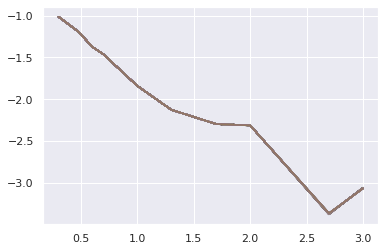

In [162]:
ax = lambdam_erf_df.plot(legend=False)
plt.show()